# NOAA challenge for benchmarking RTS

First you need to create to dataset using the original NOAA dataset with the utiliy function: 

```
python3 noaa/noaa_dot_to_coord.py -img path/to/the/images -dot /path/to/the/dotted/images -out /path/to/the/output/folder
```
The function above, create a .txt file for each image file containing the bounding boxes and class for each sea lion.


```
python3 noaa/noaa_create_model_ds.py -i /path/to/the/images -l /path/to/the/bboxes -o /path/to/the/output/folder -n 10
```

The function above create a dataset of sub images and labels for each images. The labels are the total count of sea lion for each class (adult male, sub adult male, female, ...).



# Model Training

Using the helper function load a model and train it on the newly create dataset.

In [1]:
import train_model
import matplotlib.pyplot as plt
import torch

TRAIN_PATH = "/PATH/TO/THE/DATASET"
TRAIN_PATH = "/home/remy/Documents/Model/Train"
EPOCHS = 50

#DEVICE = 'cuda'
DEVICE = 'cpu'

model = train_model.get_model(DEVICE)


/home/remy/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] initializing the ResNet50 model...
[INFO] Done


[INFO] initializing the ResNet50 model...


100%|███████| 50/50 [2:56:37<00:00, 211.96s/epochs, loss=0.104, test_loss=0.102]


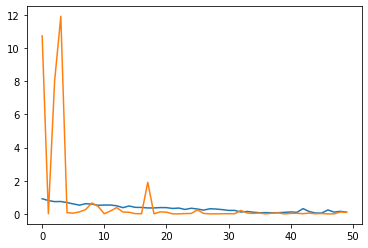

In [2]:
history, model = train_model.train(TRAIN_PATH, model, EPOCHS, DEVICE)

plt.plot(history["train_loss"])
plt.plot(history["test_loss"])
plt.show()

# Model Evaluation

Now we can do the evaluation of the model on the validation set.

In [4]:
TRAIN_PATH = "/PATH/TO/THE/DATASET"
TRAIN_PATH = "/media/remy/PHILIPS UFD/Model/Test"

print(train_model.eval(TRAIN_PATH, model, DEVICE))

(0.19231575185602362, array([0.06608255, 0.055263  , 0.06627337, 0.14943645, 0.12020089]))


In [21]:
torch.save(model, 'weights/noaa_resnet50_weights.pt')

In [16]:
import model_utility
model = torch.load("weights/noaa_resnet50_weights.pt", 
                   map_location=torch.device(DEVICE))
model = model_utility.model_wrapper(model, DEVICE)

# Visualisation

Let's see what the model is capable of. 
Below you can sea the predictions for some test images.

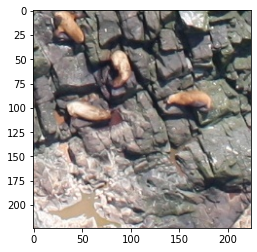

[0 0 0 0 4]


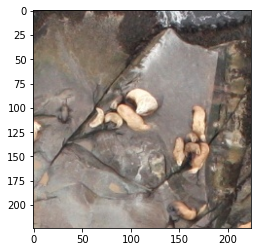

[ 1  1  0 17  4]


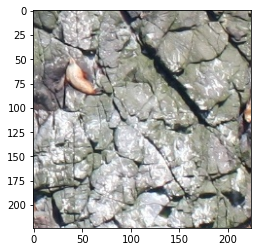

[0 0 0 0 1]


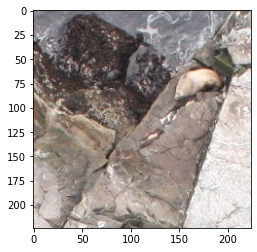

[0 0 0 0 0]


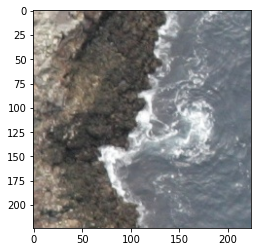

[0 0 0 0 0]


In [17]:
import os
import cv2

img_list = os.listdir("model_test_images")
for img in img_list:
    
    img = cv2.imread(os.path.join("model_test_images", img))

    # You may need to convert the color.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pred, _ = model(img)
    print(pred)
    plt.imshow(img)
    plt.show()

# Conventionnal sliding window

Now we can use a sliding window on NOAA large scale images. The goal is to count all the sea lions on each test images.

In [34]:
import time
import numpy as np

window_search = model_utility.windowed_search(model)
PREDS = {
    'time_elapsed': [],
    'seal_counts': [],
    'real_counts': []
}


img_list = os.listdir("benchmark_test_images")
for img in img_list:
    
    real_counts = [0, 0, 0, 0, 0]
    file = open(os.path.join("benchmark_test_labels", img[:-4] + ".txt"), 'r')
    lines = file.readlines()
    for line in lines:
        label = line.split(' ')[0]
        real_counts[int(label)] += 1

    
    print("------------------------------------------")
    print(img)
    print("------------------------------------------")
    
    print("Real sea lions number: \n\tadult male: {0} \
    \n\tsub adult male: {1} \
    \n\tpups: {2} \
    \n\tjuvenil: {3} \
    \n\tfemale: {4}".format(real_counts[0], 
                            real_counts[1], 
                            real_counts[2], 
                            real_counts[3], 
                            real_counts[4]))
    
    print("Processing ...")
    start = time.time()
    preds = window_search(os.path.join("benchmark_test_images", img))
    done = time.time()
    print("Done")
    
    elapsed = done - start
    print("Time elapsed: {0}".format(elapsed))
    total_counts = np.sum(np.squeeze(list(preds.values())), axis=0)
    print("Total sea lions counted: \n\tadult male: {0} \
    \n\tsub adult male: {1} \
    \n\tpups: {2} \
    \n\tjuvenil: {3} \
    \n\tfemale: {4}".format(total_counts[0], 
                            total_counts[1], 
                            total_counts[2], 
                            total_counts[3], 
                            total_counts[4]))
    
    PREDS['time_elapsed'].append(elapsed)
    PREDS['seal_counts'].append(total_counts)
    PREDS['real_counts'].append(real_counts)
    


------------------------------------------
8.jpg
------------------------------------------
Real sea lions number: 
	adult male: 7     
	sub adult male: 5     
	pups: 14     
	juvenil: 4     
	female: 74
Processing ...
Done
Time elapsed: 23.252768993377686
Total sea lions counted: 
	adult male: 97     
	sub adult male: 3     
	pups: 18     
	juvenil: 35     
	female: 240
------------------------------------------
6.jpg
------------------------------------------
Real sea lions number: 
	adult male: 2     
	sub adult male: 5     
	pups: 0     
	juvenil: 13     
	female: 18
Processing ...
Done
Time elapsed: 27.077738761901855
Total sea lions counted: 
	adult male: 88     
	sub adult male: 1     
	pups: 0     
	juvenil: 9     
	female: 103
------------------------------------------
54.jpg
------------------------------------------
Real sea lions number: 
	adult male: 2     
	sub adult male: 4     
	pups: 0     
	juvenil: 26     
	female: 22
Processing ...
Done
Time elapsed: 26.375933408737

# Results

Let's see the results.

Total time elapsed for 15 images: 383 secondes
Mean error per images: 215.93333333333334
Mean error per classes: [84.73333333  3.53333333  8.26666667 27.46666667 91.93333333]
Error rate per images:  [0.39736949 0.3035492  0.28207723 0.35400067 0.35126651 0.47285488
 0.26102485 0.13782771 0.00457277 0.41499807 0.17686274 0.41366247
 0.21047754 0.24808889 0.40429499]


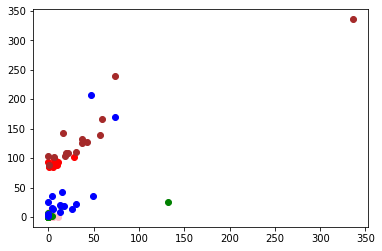

In [37]:
print("Total time elapsed for {0} images: {1} secondes".format(len(PREDS['time_elapsed']),                                                               int(np.sum(PREDS['time_elapsed']))))

real = np.array(PREDS['real_counts'])
predicted  = np.array(PREDS['seal_counts'])
error = np.absolute(real - predicted)
print("Mean error per images: {0}".format(np.sum(error, axis=1).mean()))
print("Mean error per classes: {0}".format(np.mean(error, axis=0)))
print("Error rate per images: ", np.mean(real / (error + real + 0.0000001), axis=1))

COLOR = ['red', 'pink', 'green', 'blue', 'brown']
for i in range(5):
    plt.scatter(real[:,i], predicted[:,i], color=COLOR[i])

# RTS

It's time to test our model binded with RTS. Let's see if it can perform better than the classical sliding window.

------------------------------------------
8.jpg
------------------------------------------
Real sea lions number: 
	adult male: 7     
	sub adult male: 5     
	pups: 14     
	juvenil: 4     
	female: 74
Processing ...
Done


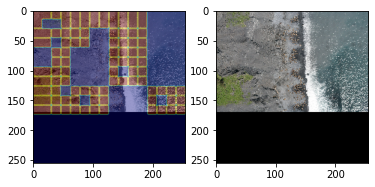

Time elapsed: 15.06477165222168
Total sea lions counted: 
	adult male: 56     
	sub adult male: 0     
	pups: 8     
	juvenil: 13     
	female: 120
------------------------------------------
6.jpg
------------------------------------------
Real sea lions number: 
	adult male: 2     
	sub adult male: 5     
	pups: 0     
	juvenil: 13     
	female: 18
Processing ...
Done


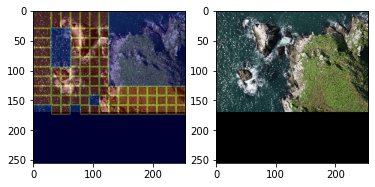

Time elapsed: 12.699253797531128
Total sea lions counted: 
	adult male: 55     
	sub adult male: 0     
	pups: 1     
	juvenil: 5     
	female: 73
------------------------------------------
54.jpg
------------------------------------------
Real sea lions number: 
	adult male: 2     
	sub adult male: 4     
	pups: 0     
	juvenil: 26     
	female: 22
Processing ...
Done


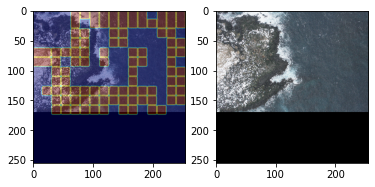

Time elapsed: 17.8426730632782
Total sea lions counted: 
	adult male: 42     
	sub adult male: 0     
	pups: 1     
	juvenil: 9     
	female: 62
------------------------------------------
87.jpg
------------------------------------------
Real sea lions number: 
	adult male: 7     
	sub adult male: 1     
	pups: 0     
	juvenil: 15     
	female: 43
Processing ...
Done


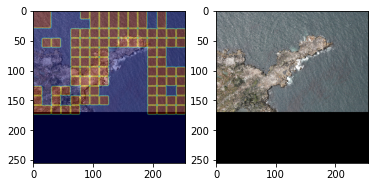

Time elapsed: 13.932873964309692
Total sea lions counted: 
	adult male: 44     
	sub adult male: 0     
	pups: 2     
	juvenil: 23     
	female: 67
------------------------------------------
59.jpg
------------------------------------------
Real sea lions number: 
	adult male: 6     
	sub adult male: 4     
	pups: 0     
	juvenil: 49     
	female: 16
Processing ...
Done


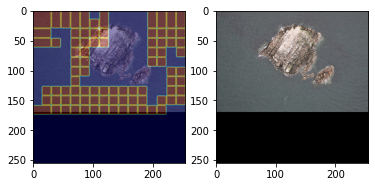

Time elapsed: 18.033454656600952
Total sea lions counted: 
	adult male: 68     
	sub adult male: 0     
	pups: 2     
	juvenil: 0     
	female: 74
------------------------------------------
43.jpg
------------------------------------------
Real sea lions number: 
	adult male: 28     
	sub adult male: 4     
	pups: 132     
	juvenil: 47     
	female: 336
Processing ...
Done


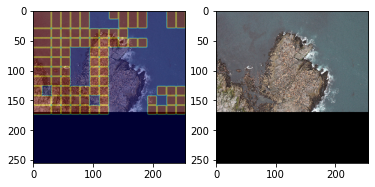

Time elapsed: 13.021131038665771
Total sea lions counted: 
	adult male: 59     
	sub adult male: 7     
	pups: 11     
	juvenil: 107     
	female: 169
------------------------------------------
13.jpg
------------------------------------------
Real sea lions number: 
	adult male: 1     
	sub adult male: 5     
	pups: 0     
	juvenil: 13     
	female: 19
Processing ...
Done


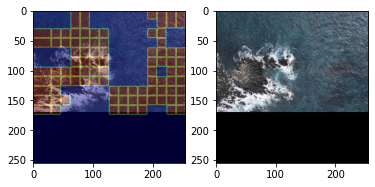

Time elapsed: 18.471943140029907
Total sea lions counted: 
	adult male: 38     
	sub adult male: 0     
	pups: 0     
	juvenil: 11     
	female: 57
------------------------------------------
18.jpg
------------------------------------------
Real sea lions number: 
	adult male: 2     
	sub adult male: 2     
	pups: 0     
	juvenil: 0     
	female: 0
Processing ...
Done


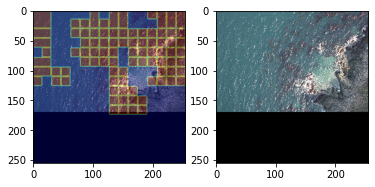

Time elapsed: 13.234938144683838
Total sea lions counted: 
	adult male: 16     
	sub adult male: 0     
	pups: 0     
	juvenil: 0     
	female: 20
------------------------------------------
37.jpg
------------------------------------------
Real sea lions number: 
	adult male: 1     
	sub adult male: 0     
	pups: 0     
	juvenil: 0     
	female: 1
Processing ...
Done


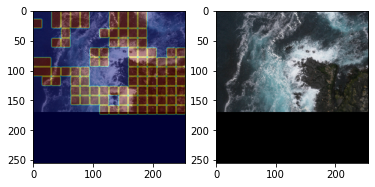

Time elapsed: 17.014596223831177
Total sea lions counted: 
	adult male: 39     
	sub adult male: 0     
	pups: 2     
	juvenil: 0     
	female: 48
------------------------------------------
39.jpg
------------------------------------------
Real sea lions number: 
	adult male: 10     
	sub adult male: 11     
	pups: 4     
	juvenil: 5     
	female: 57
Processing ...
Done


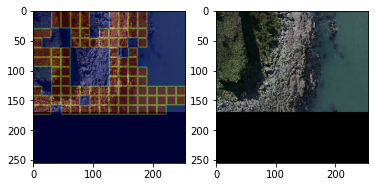

Time elapsed: 14.371013641357422
Total sea lions counted: 
	adult male: 57     
	sub adult male: 0     
	pups: 2     
	juvenil: 12     
	female: 117
------------------------------------------
10.jpg
------------------------------------------
Real sea lions number: 
	adult male: 5     
	sub adult male: 4     
	pups: 0     
	juvenil: 4     
	female: 6
Processing ...
Done


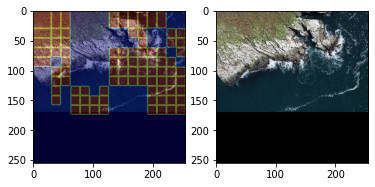

Time elapsed: 17.239639043807983
Total sea lions counted: 
	adult male: 32     
	sub adult male: 0     
	pups: 1     
	juvenil: 9     
	female: 41
------------------------------------------
16.jpg
------------------------------------------
Real sea lions number: 
	adult male: 1     
	sub adult male: 1     
	pups: 0     
	juvenil: 31     
	female: 31
Processing ...
Done


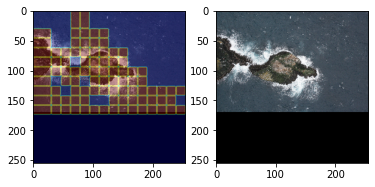

Time elapsed: 14.76102876663208
Total sea lions counted: 
	adult male: 66     
	sub adult male: 0     
	pups: 0     
	juvenil: 16     
	female: 99
------------------------------------------
55.jpg
------------------------------------------
Real sea lions number: 
	adult male: 6     
	sub adult male: 2     
	pups: 0     
	juvenil: 74     
	female: 59
Processing ...
Done


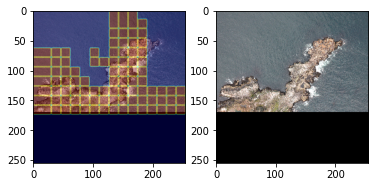

Time elapsed: 16.704550743103027
Total sea lions counted: 
	adult male: 77     
	sub adult male: 5     
	pups: 0     
	juvenil: 111     
	female: 134
------------------------------------------
82.jpg
------------------------------------------
Real sea lions number: 
	adult male: 0     
	sub adult male: 0     
	pups: 0     
	juvenil: 17     
	female: 37
Processing ...
Done


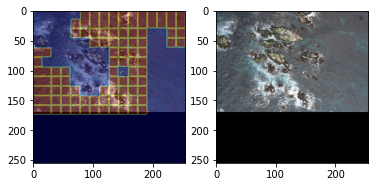

Time elapsed: 14.5313138961792
Total sea lions counted: 
	adult male: 58     
	sub adult male: 0     
	pups: 0     
	juvenil: 8     
	female: 72
------------------------------------------
79.jpg
------------------------------------------
Real sea lions number: 
	adult male: 11     
	sub adult male: 5     
	pups: 1     
	juvenil: 0     
	female: 37
Processing ...
Done


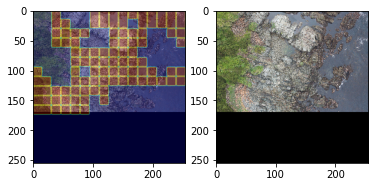

Time elapsed: 17.849175214767456
Total sea lions counted: 
	adult male: 27     
	sub adult male: 0     
	pups: 1     
	juvenil: 16     
	female: 58


In [32]:
import sys
sys.path.insert(0, '../rts')
import rts
import time
import numpy as np

rts.rts.MODEL_RES = 224
rts_agent = rts.rts.RTS(model)

PREDS_RTS = {
    'time_elapsed': [],
    'seal_counts': [],
    'real_counts': []
}


img_list = os.listdir("benchmark_test_images")
for img in img_list:
    
    real_counts = [0, 0, 0, 0, 0]
    file = open(os.path.join("benchmark_test_labels", img[:-4] + ".txt"), 'r')
    lines = file.readlines()
    for line in lines:
        label = line.split(' ')[0]
        real_counts[int(label)] += 1

    
    print("------------------------------------------")
    print(img)
    print("------------------------------------------")
    
    print("Real sea lions number: \n\tadult male: {0} \
    \n\tsub adult male: {1} \
    \n\tpups: {2} \
    \n\tjuvenil: {3} \
    \n\tfemale: {4}".format(real_counts[0], 
                            real_counts[1], 
                            real_counts[2], 
                            real_counts[3], 
                            real_counts[4]))
    
    print("Processing ...")
    img = cv2.imread(os.path.join("benchmark_test_images", img))
    start = time.time()
    preds = rts_agent(img)
    done = time.time()
    print("Done")
    
    _, axes = plt.subplots(1, 2)
    axes[0].imshow(cv2.cvtColor(rts_agent.get_trajectory(), cv2.COLOR_RGB2BGR))
    axes[1].imshow(cv2.resize(rts_agent.env.full_img, (255, 255)))
    plt.show()
    
    elapsed = done - start
    print("Time elapsed: {0}".format(elapsed))
    total_counts = np.sum(np.squeeze(list(preds.values())), axis=0)
    print("Total sea lions counted: \n\tadult male: {0} \
    \n\tsub adult male: {1} \
    \n\tpups: {2} \
    \n\tjuvenil: {3} \
    \n\tfemale: {4}".format(total_counts[0], 
                            total_counts[1], 
                            total_counts[2], 
                            total_counts[3], 
                            total_counts[4]))
    
    PREDS_RTS['time_elapsed'].append(elapsed)
    PREDS_RTS['seal_counts'].append(total_counts)
    PREDS_RTS['real_counts'].append(real_counts)
    

Total time elapsed for 15 images: 234 secondes
Mean error per images: 124.46666666666667
Mean error per classes: [43.          3.53333333  9.2        16.13333333 52.6       ]
Error rate per images:  [0.44987179 0.28039732 0.30142178 0.39061117 0.2608903  0.53499767
 0.34526316 0.125      0.00929487 0.44919028 0.24940718 0.30043917
 0.31697745 0.23354701 0.50906767]
Mean missing sea lion per images:  126.53333333333333


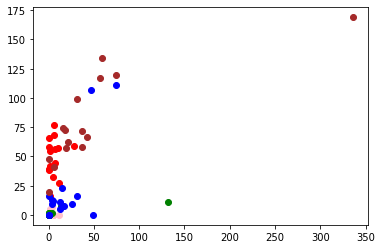

In [49]:
print("Total time elapsed for {0} images: {1} secondes".format(len(PREDS_RTS['time_elapsed']),
                                                               int(np.sum(PREDS_RTS['time_elapsed']))))

real = np.array(PREDS_RTS['real_counts'])
predicted  = np.array(PREDS_RTS['seal_counts'])
predicted_conv  = np.array(PREDS['seal_counts'])

error = np.absolute(real - predicted)
print("Mean error per images: {0}".format(np.sum(error, axis=1).mean()))
print("Mean error per classes: {0}".format(np.mean(error, axis=0)))
print("Error rate per images: ", np.mean(real / (error + real + 0.0000001), axis=1))

error_rts = np.absolute(predicted_conv - predicted)

print("Mean missing sea lion per images: ", np.mean(np.sum(error_rts, axis=1)))

COLOR = ['red', 'pink', 'green', 'blue', 'brown']
for i in range(5):
    plt.scatter(real[:,i], predicted[:,i], color=COLOR[i])

# Conclusion